In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus
from matplotlib import pyplot as plt
import time

pyLDAvis.enable_notebook()
nltk.download('wordnet')
nltk.download('stopwords')
#sklearn.decomposition.LatentDirichletAllocation

[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('data.csv')
data.fillna('', inplace=True)
data.head()

,contest,problem_name,problem_statement,problem_tags
0,325,A,You are given n rectangles. The corners of rec...,"implementation,*1500"
1,325,B,Daniel is organizing a football tournament. He...,"binarysearch,math,*1800"
2,325,C,Piegirl has found a monster and a book about m...,"dfsandsimilar,graphs,shortestpaths,*2600"
3,325,D,"In a far away land, there exists a planet shap...","dsu,*2900"
4,325,E,Piegirl found the red button. You have one las...,"combinatorics,dfsandsimilar,dsu,graphs,greedy,..."


In [3]:
print(f'quantidade de problemas: {data.shape[0]}')
print(f'quantidade de contests: {len(data.contest.unique())}')
print(f'problemas repetidos: {data.shape[0] - len(data.problem_statement.unique())}')

data.drop_duplicates(subset='problem_statement', inplace=True)

quantidade de problemas: 8343
quantidade de contests: 1424
problemas repetidos: 1524


## Pre-processamento

In [4]:
sw = stopwords.words('english')
sw += ['input', 'output', 'th', 'print', 'test', 'case', 'line']
lemma = WordNetLemmatizer()
text = data.problem_statement

# Problem_statement
print(text[8341])
print('------------')
text = text.apply(lambda x: re.sub(r'\${1,3}(.*?)\${1,3}', ' ',x))
text = text.apply(lambda x: re.sub(r'(?:\\)[a-zA-Z]+', ' ',x))
text = text.apply(lambda x: re.sub(r'\{(.*?)\}', ' ',x))
text = text.apply(lambda x: re.sub(r"[\,|\.|\(|\)|\!|\?|\:|\']",' ',x)) # removendo caracteres especiais
text = text.apply(lambda x: [i for i in x.split() if i.lower() not in sw]) # removendo stop-words
text = text.apply(lambda x: ' '.join([lemma.lemmatize(i) for i in x])) # lemmatizando todo

# Topics
topics = data.problem_tags
topics = topics.apply(lambda x: re.sub('[*][0-9]+','',x)) # remove os ratings *800 etc
topics = topics.apply(lambda x: [i for i in x.split(',') if i != '']) # tira strings vazias

print(text[8341])


At first, let's define function $$$f(x)$$$ as follows: $$$$$$ \begin{matrix} f(x) & = & \left\{ \begin{matrix} \frac{x}{2} & \mbox{if } x \text{ is even} \\ x - 1 & \mbox{otherwise } \end{matrix} \right. \end{matrix} $$$$$$

We can see that if we choose some value $$$v$$$ and will apply function $$$f$$$ to it, then apply $$$f$$$ to $$$f(v)$$$, and so on, we'll eventually get $$$1$$$. Let's write down all values we get in this process in a list and denote this list as $$$path(v)$$$. For example, $$$path(1) = [1]$$$, $$$path(15) = [15, 14, 7, 6, 3, 2, 1]$$$, $$$path(32) = [32, 16, 8, 4, 2, 1]$$$.

Let's write all lists $$$path(x)$$$ for every $$$x$$$ from $$$1$$$ to $$$n$$$. The question is next: what is the maximum value $$$y$$$ such that $$$y$$$ is contained in at least $$$k$$$ different lists $$$path(x)$$$?

Formally speaking, you need to find maximum $$$y$$$ such that $$$\left| \{ x ~|~ 1 \le x \le n, y \in path(x) \} \right| \ge k$$$.

The first line contains two integers $$$n$$$ an

In [5]:
text

0       given n rectangle corner rectangle integer coo...
1       Daniel organizing football tournament come fol...
2       Piegirl found monster book monster pie reading...
3       far away land exists planet shaped like cylind...
4       Piegirl found red button one last chance chang...
                              ...                        
8338    block arranged row numbered left right startin...
8339    map capital Berland viewed infinite coordinate...
8340    play strategic video game yeah ran good proble...
8341    first let define function follows f x & = & \ ...
8342    Recently lot student enrolled Berland State Un...
Name: problem_statement, Length: 6819, dtype: object

In [6]:
topics

0                                        [implementation]
1                                    [binarysearch, math]
2                  [dfsandsimilar, graphs, shortestpaths]
3                                                   [dsu]
4       [combinatorics, dfsandsimilar, dsu, graphs, gr...
                              ...                        
8338                                       [greedy, math]
8339       [bruteforce, geometry, greedy, implementation]
8340    [datastructures, dp, greedy, implementation, s...
8341              [binarysearch, combinatorics, dp, math]
8342                                         [bruteforce]
Name: problem_tags, Length: 6819, dtype: object

In [7]:
lista = topics.to_list()

d = dict()
for x in lista:
    for y in x:
        if y not in d:
            d[y]= 1
        else:
            d[y]+=1

x= sorted(d.items(), key=lambda item:item[1], reverse=True)

for i in x:
    print(i)



('implementation', 1970)
('math', 1733)
('greedy', 1645)
('dp', 1373)
('datastructures', 1076)
('bruteforce', 1020)
('constructivealgorithms', 981)
('graphs', 720)
('sortings', 658)
('binarysearch', 652)
('dfsandsimilar', 590)
('trees', 511)
('strings', 484)
('numbertheory', 453)
('combinatorics', 390)
('*specialproblem', 367)
('twopointers', 310)
('bitmasks', 300)
('geometry', 291)
('dsu', 210)
('shortestpaths', 174)
('divideandconquer', 167)
('probabilities', 162)
('hashing', 136)
('games', 131)
('interactive', 114)
('flows', 99)
('matrices', 87)
('stringsuffixstructures', 64)
('fft', 56)
('graphmatchings', 54)
('ternarysearch', 40)
('meet-in-the-middle', 33)
('expressionparsing', 32)
('2-sat', 19)
('chineseremaindertheorem', 10)
('schedules', 5)


## Vetorizando

In [8]:
max_df = 0.8
min_df = 0.05
vec = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=(1,3))

In [9]:
def vect2gensim(vectorizer, dtmatrix):
    # transform sparse matrix into gensim corpus and dictionary
    corpus_vect_gensim = Sparse2Corpus(dtmatrix, documents_columns=False)
    dictionary = Dictionary.from_corpus(corpus_vect_gensim,
            id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))
    return (corpus_vect_gensim, dictionary)



In [10]:
X = vec.fit_transform(text)
X.shape
X = vect2gensim(vec, X)

## Agrupando

In [11]:
# Pegando quantidade de topicos

total_topics = set()
topics = topics.apply(lambda x: [total_topics.add(i) for i in x])

In [12]:
n_total_topics = len(total_topics)
print(f'Número de Tópicos: {n_total_topics}')
total_topics

Número de Tópicos: 37


{'*specialproblem',
 '2-sat',
 'binarysearch',
 'bitmasks',
 'bruteforce',
 'chineseremaindertheorem',
 'combinatorics',
 'constructivealgorithms',
 'datastructures',
 'dfsandsimilar',
 'divideandconquer',
 'dp',
 'dsu',
 'expressionparsing',
 'fft',
 'flows',
 'games',
 'geometry',
 'graphmatchings',
 'graphs',
 'greedy',
 'hashing',
 'implementation',
 'interactive',
 'math',
 'matrices',
 'meet-in-the-middle',
 'numbertheory',
 'probabilities',
 'schedules',
 'shortestpaths',
 'sortings',
 'strings',
 'stringsuffixstructures',
 'ternarysearch',
 'trees',
 'twopointers'}

In [13]:
def run_lda(qtd_topics, iter):
    n_components = qtd_topics
    max_iter = iter

    id2word = X[1]
    corpus = X[0]

    lda = LdaModel(corpus=corpus, num_topics=n_components, id2word=id2word, iterations=max_iter)

    return lda

In [14]:
lda = run_lda(qtd_topics=n_total_topics, iter=100)

In [15]:
# lda_matrix = lda.fit_transform(X)



In [16]:
# top_word = lda.components_
# terms = vec.get_feature_names_out()

# for i, comp in enumerate(top_word):
#     top_terms_key = zip(terms, comp)
#     top_terms_key= sorted(top_terms_key, key = lambda t: t[1], reverse=True)[:10]
#     top_terms_list= list(dict(top_terms_key).keys())
#     print("Topic "+str(i)+": ",top_terms_list)

## Validando

In [17]:
def get_coherence(lda):
    corpus = X[0]
    id2word = X[1]
    new_model = CoherenceModel(model=lda, texts=text, corpus=corpus, dictionary=id2word, coherence="u_mass")
    return new_model.get_coherence()

In [18]:


print(get_coherence(lda))

# todo -> entender metrica de coerencia
#      -> usar dentro dos atributos o que ja foi calculado no CountVectorizer

-1.262384836875163


# Analisando Hiperparâmetros

## Teste 1

In [19]:
list_coherence = []
for i in range(1, 38):

    lda = run_lda(qtd_topics = i, iter=100)
    coherence = get_coherence(lda)

    list_coherence.append(coherence)


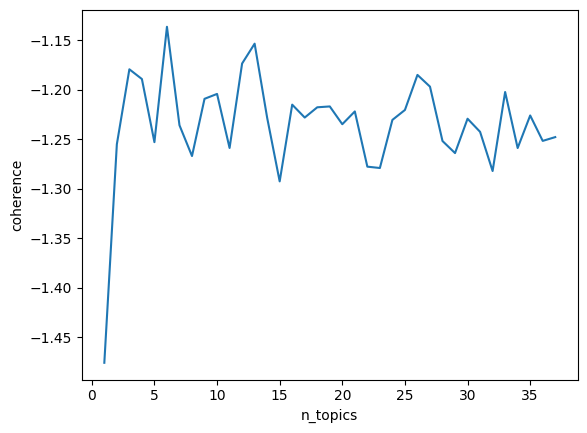

In [20]:
list_coherence

plt.plot([i for i in range(1,38)], list_coherence)
plt.xlabel('n_topics')
plt.ylabel('coherence')
plt.show()


## Teste 2

In [21]:
list_coherence2 = []
list_times = []
for i in range(100, 1000, 100):

    print(i)
    time_before = time.time()
    lda = run_lda(qtd_topics=5, iter=i)
    time_later = time.time()
    time_total = time_later-time_before
    coherence = get_coherence(lda)

    list_times.append(time_total)
    list_coherence2.append(coherence)

100
200
300
400
500
600
700
800
900


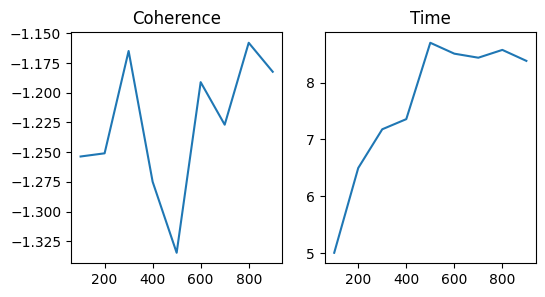

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), sharey=False)
ax[0].plot([i for i in range(100, 1000, 100)], list_coherence2, label="coherence")
ax[1].plot([i for i in range(100, 1000, 100)], list_times, label="time")

ax[0].set_title("Coherence")
ax[1].set_title("Time")
# plt.ylim([-1, 1])
plt.show()

## Visualizando

In [24]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
corpus = X[0]
id2word = X[1]

panel = pyLDAvis.gensim.prepare(lda, corpus, dictionary=id2word)
panel
# todo 
# mudar para o modelo do gensim

/home/victor/anaconda3/envs/pibic/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.060927  0.027256       1        1  24.332551
0     -0.026323 -0.078057       2        1  24.230313
3     -0.027248  0.034179       3        1  22.750294
4      0.069196 -0.009027       4        1  17.240112
1      0.045301  0.025648       5        1  11.446729, topic_info=         Term         Freq        Total Category  logprob  loglift
218    string  6735.000000  6735.000000  Default  30.0000  30.0000
257     array  4988.000000  4988.000000  Default  29.0000  29.0000
93       city  2226.000000  2226.000000  Default  28.0000  28.0000
101      cell  3717.000000  3717.000000  Default  27.0000  27.0000
111  sequence  4854.000000  4854.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
49      order   418.201694  3680.201779   Topic5  -4.8874  -0.0073
14     single   461.300391  5022.842369   Topic5  -4.7893  -0.2202
11        set   359.467000  2868.270060   Topic5  -5.0388   0.0906
159    answer   413.961715  4989.645780   Topic5  -4.8976  -0.3219
36    example   451.456251  7286.571229   Topic5  -4.8109  -0.6138

[282 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
309       1  0.227599   000
309       2  0.230517   000
309       3  0.214468   000
309       4  0.103587   000
309       5  0.224681   000
...     ...       ...   ...
59        1  0.130366  zero
59        2  0.354139  zero
59        3  0.074591  zero
59        4  0.352795  zero
59        5  0.088031  zero

[855 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 5, 2])